In [1]:
import sys, cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import collections

# Reading Dumped data

In [2]:
with open('sortedFish.pik','rb') as f:
    sortedFish=pickle.load(f)

posU=sortedFish[0]
nonOverlappingRange=sortedFish[1]
fishU=sortedFish[2]

fishU=frame,fish,pixel,[row,col,grey]

262 30 113.57956808685125


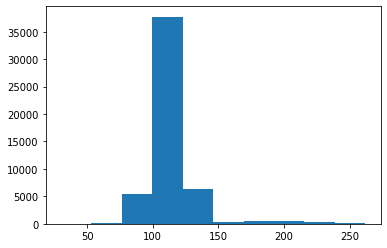

TypeError: '<' not supported between instances of 'list' and 'int'

In [39]:
pixelCount=[]
for i in range(len(fishU)):
    pixelCount.append(len(fishU[i][0]))
print(max(pixelCount),min(pixelCount),np.mean(pixelCount))
plt.hist(pixelCount)
plt.show()
print(np.where(pixelCount<150,pixelCount))

# Creating a distance histogram out of the sorted data

### Creating histograms for the first fish over the first nonoverlapping range

In [3]:
binsDist=np.linspace(0,30,20)
binsDif=np.linspace(0,50,20)
binsSum=np.linspace(150,350,20)
histSum=np.zeros((len(binsDist)-1,len(binsSum)-1))
histDif=np.zeros((len(binsDist)-1,len(binsDif)-1))

pairData=[]
countSum=0
countDif=0
for k in range(*nonOverlappingRange[0]):
    fishA=fishU[k][0]
    for i in range(fishA.shape[0]):
        for j in range(i):
            d=np.sqrt((fishA[i,0]-fishA[j,0])**2+(fishA[i,1]-fishA[j,1])**2)
            bSum=fishA[i,2]+fishA[j,2]
            bDiff=fishA[i,2]-fishA[j,2]
            pairData.append([d,bSum,bDiff])
    pairDataT = np.array(pairData).T
    heightValuesSum,_,_=np.histogram2d(pairDataT[0],pairDataT[1],bins=(binsDist,binsSum))
    histSum+=heightValuesSum
    countSum+=1
    heightValuesDif,_,_=np.histogram2d(pairDataT[0],pairDataT[2],bins=(binsDist,binsDif))
    histDif+=heightValuesDif
    countDif+=1
histSum/=countSum
histDif/=countDif

In [ ]:
fig=plt.figure(figsize=(10,5))

ax = fig.add_subplot(121)
plt.imshow(histSum[:,::-1].T,extent=[binsDist[0], binsDist[-1], binsSum[0], binsSum[-1]],aspect='auto')

ax = fig.add_subplot(122)
plt.imshow(histDif[:,::-1].T,extent=[binsDist[0], binsDist[-1], binsDif[0], binsDif[-1]],aspect='auto')

plt.show()

### Function to create histograms

In [ ]:
def histMaker(histData,bins1,bins2):
    '''
    Creates a 2d histogram.
    
    Input:
        histData:Either histSum or histDif. Some sort of array?
        bins1:The distance bins. np.linspace(int,int,int)
        bins2:The sum/difference bins. np.linspace(int,int,int)
    '''
    #fig=plt.figure(figsize=(5,5))
    
    plt.imshow(histData[:,::-1].T,extent=[bins1[0], bins1[-1], bins2[0], bins2[-1]],aspect='auto')
    plt.colorbar()
    
    #plt.show()

### Creating histograms for two fish over the first two nonoverlapping ranges.

In [4]:
binsDist=np.linspace(0,30,20)
binsDif=np.linspace(0,50,20)
binsSum=np.linspace(150,350,20)
histSum=np.zeros((len(binsDist)-1,len(binsSum)-1))
histDif=np.zeros((len(binsDist)-1,len(binsDif)-1))

histSumList={}
histDifList={}

#i=num nonOverlappingRanges
#k=num fish
#j=frame in nonOverlappingRange
#l=pixels in frame
#m=

for i in range(2):
    for k in range(2):
        countSum=0
        countDif=0
        pairData=[]
        for j in range(*nonOverlappingRange[i]):
            fishList = fishU[j][k]
            for l in range(fishList.shape[0]):
                for m in range(l):
                    d=np.sqrt((fishList[l,0]-fishList[m,0])**2+(fishList[l,1]-fishList[m,1])**2)
                    bSum=fishList[l,2]+fishList[m,2]
                    bDif=fishList[l,2]-fishList[m,2]
                    pairData.append([d,bSum,bDif])
            pairDataT = np.array(pairData).T
            heightValuesSum,_,_=np.histogram2d(pairDataT[0],pairDataT[1],bins=(binsDist,binsSum))
            histSum+=heightValuesSum
            countSum+=1
            heightValuesDif,_,_=np.histogram2d(pairDataT[0],pairDataT[2],bins=(binsDist,binsDif))
            histDif+=heightValuesDif
            countDif+=1
        histSum/=countSum
        #histSumList['nonOverlappingRange%s-fish%s'%(i,k)]=histSum.copy()
        #nonOverlappingRange,fish
        histSumList[i,k]=histSum.copy()
        histDif/=countDif
        #histDifList['nonOverlappingRange%s-fish%s'%(i,k)]=histDif.copy()
        #nonOverlappingRange,fish
        histDifList[i,k]=histDif.copy()

In [ ]:
plt.figure(figsize=(10,10))
for i,k in enumerate(histSumList.keys()):
    plt.subplot(2,2,i+1)
    histMaker(histSumList[k],binsDist,binsSum)
    plt.title(f'nonOverlappingRange{k[0]}, fish{k[1]}')
plt.show()

### Checking distances between the histograms

# Use scipy.spatial.distance.cdist instead?

In [15]:
def swapStatus(histDict):
    '''
    Detext swaps between consecutive nonOverlappingRanges based on brightness sum and difference.
    
    Input:
        histList: . Dictionary
    
    Output:
        Int. 0 if no swaps, 1 if swapped, 2 if overlapping.
    '''
    
    histList=list(histDict.values())
    
    distanceMatrix=[np.linalg.norm(histList[2]-histList[0]),
        np.linalg.norm(histList[2]-histList[1]),
        np.linalg.norm(histList[3]-histList[0]),
        np.linalg.norm(histList[3]-histList[1])]
    
    swapCriteron=(distanceMatrix[0]+distanceMatrix[1])-(distanceMatrix[2]+distanceMatrix[3])
    if abs(swapCriteron)<1e-10:
        return 2 #Overlapping
    elif swapCriteron>0:
        return 1 #Swapped
    elif swapCriteron<0:
        return 0 #Normal
    else:
        return -1

In [16]:
swapStatus(histSumList)

0

In [ ]:
H=histDifList